# HSCT survival: Weibull accelerated failure model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-no_multicollinearity_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'
survival_functions_file=f'{config.DATA_PATH}/processed/04.2-weibullAFT_survival_functions.parquet'
survival_probabilities_file=f'{config.DATA_PATH}/processed/04.2-weibullAFT_160_week_survival_probabilities.parquet'


## 1. Load data

Feature types:

True numerical features
['donor_age', 'age_at_hct', 'year_hct', 'efs_time']

Ordinal features
['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

True categorical features
['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan

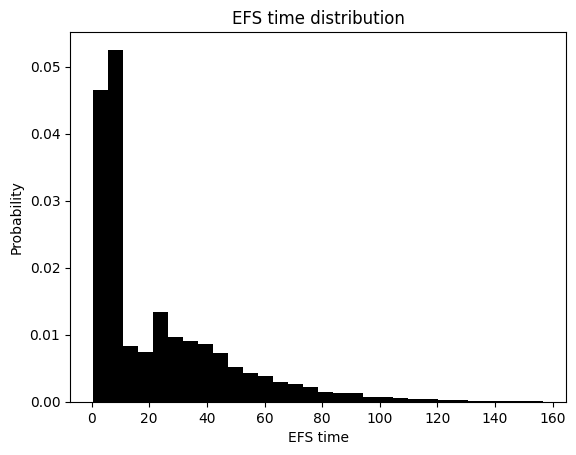

Training features: (28800, 118)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

with open(feature_types_dict_file, 'rb') as input_file:
    feature_types_dict=pickle.load(input_file)
    
# Load feature type definitions
print('Feature types:\n')
for feature_type, features in feature_types_dict.items():
    print(f'{feature_type}\n{features}\n')

# Combine feature lists for ordinal and true numerical features
numerical_features=feature_types_dict['True numerical features'] + feature_types_dict['Ordinal features']

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

In [3]:
data_df.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,donor_related_Related,donor_related_Unrelated,"melphalan_dose_N/A, Mel not given",cardiac_Yes,pulm_moderate_Yes,efs,race_group
ID,,,,,,,,,,,,,,,,,,,,,
0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,1,1,0,0,0,More than one race
1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,1,0,1,0,1,1,Asian
2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,1,0,1,0,0,0,More than one race
3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,1,1,0,0,0,White
4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,2.0,...,0,0,1,1,0,0,0,0,0,American Indian or Alaska Native


## 2. Data preparation

### 2.1 Train-test split

In [4]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

### 2.2. Save and remove training & testing race group

In [5]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

## 3. Weibull AFT model

### 3.1. Naive model

In [6]:
training_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)
testing_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)

# training_df['efs_time']=training_df['efs_time']/100
# testing_df['efs_time']=testing_df['efs_time']/100

waft_model=WeibullAFTFitter(penalizer=0.01)
waft_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.WeibullAFTFitter: fitted with 19296 total observations, 8876 right-censored observations>

In [7]:
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
                penalizer = 0.01
   number of observations = 19296
number of events observed = 10420
           log-likelihood = -45700.08
         time fit was run = 2025-02-20 13:22:33 UTC

---
                                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                                             
lambda_ age_at_hct                                           -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
        arrhythmia_Yes                                       -0.05      0.96      0.06           -0.17            0.08                0.85                1.08
        cardiac_Yes                                          -0.47      0.62      0.05           -0.58           -0.36                0.56                0.69
        cmv_status                                           -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
        comorbidity_score                                    -0.08      0.92      0.01           -0.09           -0.06                0.91                0.94
        conditioning_intensity_N/A, F(pre-TED) not submitted  0.26      1.30      0.31           -0.34            0.87                0.71                2.38
        conditioning_intensity_NMA                            0.04      1.04      0.05           -0.05            0.13                0.95                1.14
        conditioning_intensity_No drugs reported             -0.15      0.86      0.25           -0.64            0.34                0.53                1.41
        conditioning_intensity_RIC                           -0.27      0.76      0.03           -0.34           -0.21                0.71                0.81
        cyto_score                                           -0.07      0.93      0.01           -0.10           -0.04                0.91                0.96
        cyto_score_detail                                    -0.29      0.75      0.02           -0.32           -0.25                0.72                0.78
        diabetes_Yes                                         -0.22      0.80      0.04           -0.29           -0.15                0.75                0.86
        donor_age                                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        donor_related_Related                                -0.00      1.00      0.08           -0.16            0.16                0.85                1.18
        donor_related_Unrelated                              -0.10      0.90      0.08           -0.27            0.06                0.77                1.06
        dri_score                                            -0.12      0.89      0.01           -0.14           -0.10                0.87                0.91
        ethnicity_Non-resident of the U.S.                   -0.01      0.99      0.14           -0.29            0.27                0.75                1.31
        ethnicity_Not Hispanic or Latino                      0.06      1.06      0.04           -0.03            0.15                0.97                1.16
        graft_type_Peripheral blood                          -0.20      0.82      0.06           -0.32           -0.09                0.73                0.92
        gvhd_proph_CDselect alone                             0.35      1.42      0.19           -0.02            0.72                0.98                2.06
        gvhd_proph_CSA + MMF +- others(not FK)               -0.07      0.93      0.09           -0.26            0.11              

### 3.3. Select features with p < 0.001

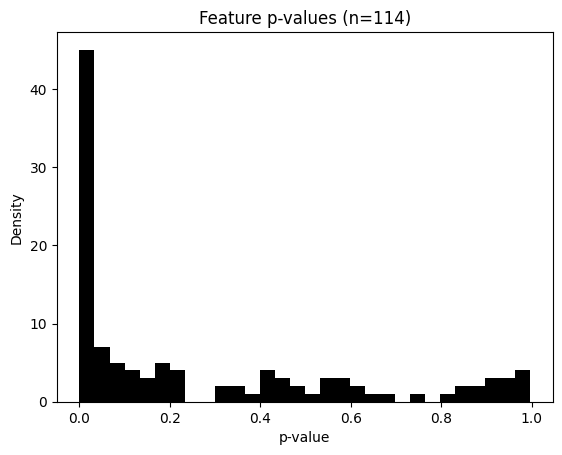

Significant features at alpha = 0.05: 48
Significant features at alpha = 0.001: 32


In [8]:
feature_pvals=waft_model.summary['p']
feature_pvals=feature_pvals.droplevel(0)
feature_pvals.drop('Intercept', axis=0, inplace=True)

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(feature_pvals, color='black', bins=30)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

In [9]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < 0.001].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < 0.001].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

waft_model=WeibullAFTFitter(penalizer=0.01)
waft_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
                penalizer = 0.01
   number of observations = 19296
number of events observed = 10420
           log-likelihood = -45888.52
         time fit was run = 2025-02-20 13:22:46 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                              
lambda_ age_at_hct                            -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
        cardiac_Yes                           -0.47      0.63      0.05           -0.57           -0.36                0.56                0.70
        comorbidity_score                     -0.08      0.92      0.01           -0.10           -0.07                0.91                0.93
        conditioning_intensity_RIC            -0.24      0.78      0.03           -0.30           -0.19                0.74                0.83
        cyto_score                            -0.07      0.93      0.01           -0.10           -0.05                0.91                0.95
        cyto_score_detail                     -0.28      0.75      0.02           -0.32           -0.25                0.73                0.78
        diabetes_Yes                          -0.23      0.80      0.04           -0.30           -0.16                0.74                0.85
        dri_score                             -0.13      0.87      0.01           -0.15           -0.11                0.86                0.89
        graft_type_Peripheral blood           -0.35      0.71      0.04           -0.42           -0.27                0.66                0.76
        gvhd_proph_Cyclophosphamide +- others  0.29      1.34      0.05            0.19            0.40                1.21                1.49
        hepatic_severe_Yes                     0.35      1.42      0.07            0.21            0.50                1.23                1.64
        hla_match_b_low                       -0.13      0.88      0.05           -0.22           -0.04                0.81                0.96
        hla_match_drb1_high                   -0.14      0.87      0.05           -0.23           -0.05                0.79                0.95
        in_vivo_tcd_Yes                        0.34      1.40      0.03            0.28            0.40                1.32                1.49
        karnofsky_score                        0.01      1.01      0.00            0.01            0.01                1.01                1.01
        mrd_hct_Positive                       0.10      1.10      0.03            0.03            0.16                1.03                1.18
        prim_disease_hct_HIS                   1.40      4.07      0.19            1.04            1.77                2.82                5.88
        prim_disease_hct_IEA                   0.88      2.41      0.09            0.70            1.06                2.01                2.89
        prim_disease_hct_IIS                   1.27      3.58      0.12            1.04            1.51                2.84                4.51
        prim_disease_hct_PCD                   0.59      1.80      0.10            0.39            0.78                1.48                2.18
        prim_disease_hct_SAA                   0.50      1.65      0.11            0.29            0.71                1.34                2.04
        psych_disturb_Yes                     -0.15      0.86      0.04           -0.23           -0.08                0.79                0.93
        pulm_severe_Yes                       -0.28      0.75      0.05           -0.39           -0.18                0.68                0.84
        race_group_Black or Af

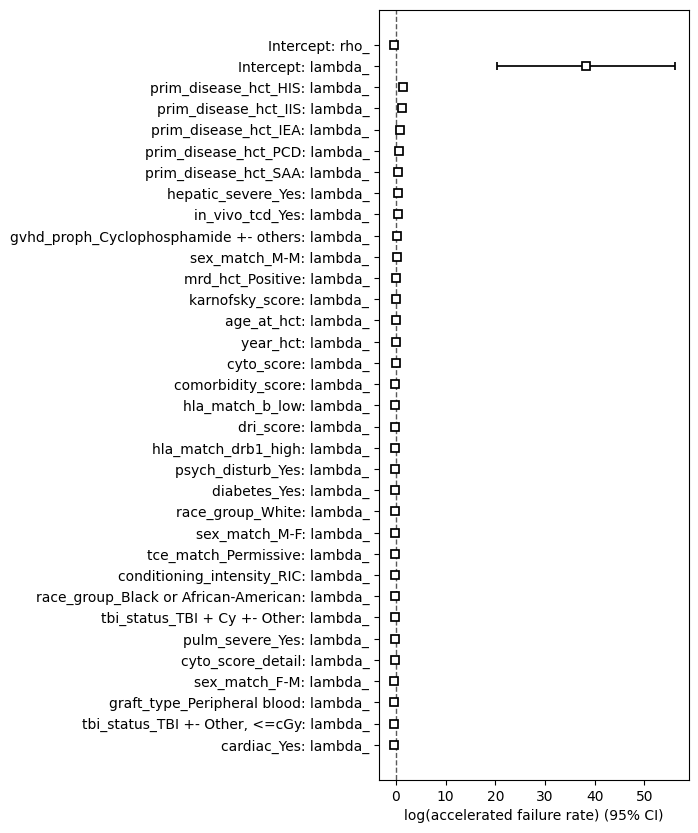

In [10]:
fig=plt.figure(figsize=[4,10])
waft_model.plot(figure=fig)
plt.show()

## 4. Survival forecasting

In [11]:
# Predict new survival function for all subjects
training_survival_functions=waft_model.predict_survival_function(training_significant_features_df)
training_survival_df=pd.concat([training_significant_features_df, training_survival_functions.iloc[-1]], axis=1)

# Predict new survival function for all subjects
testing_survival_functions=waft_model.predict_survival_function(testing_significant_features_df)
testing_survival_df=pd.concat([testing_significant_features_df,testing_survival_functions.iloc[-1]], axis=1)

training_survival_df.head()

,age_at_hct,cardiac_Yes,comorbidity_score,conditioning_intensity_RIC,cyto_score,cyto_score_detail,diabetes_Yes,dri_score,graft_type_Peripheral blood,gvhd_proph_Cyclophosphamide +- others,...,sex_match_F-M,sex_match_M-F,sex_match_M-M,tbi_status_TBI + Cy +- Other,"tbi_status_TBI +- Other, <=cGy",tce_match_Permissive,year_hct,efs,efs_time,156.819
ID,,,,,,,,,,,,,,,,,,,,,
1044,48.465,0,1.0,0,2.4,1.8,0,1.0,1,0,...,0,0,1,0,0,1,2013,1,10.592,0.182155
9306,9.511,0,3.0,0,3.6,2.4,0,0.0,0,1,...,0,0,0,0,0,0,2016,0,40.171,0.381003
24307,34.506,0,0.0,0,2.6,2.4,0,4.0,0,0,...,0,0,0,0,0,0,2017,1,6.128,0.239822
1058,65.872,0,1.0,1,2.2,1.0,0,4.0,1,0,...,1,0,0,0,0,0,2011,0,125.803,0.018144
24177,9.600,0,1.0,0,3.0,1.0,0,0.0,0,0,...,0,1,0,0,0,0,2017,0,39.575,0.387497


### 4.1. Survival curves

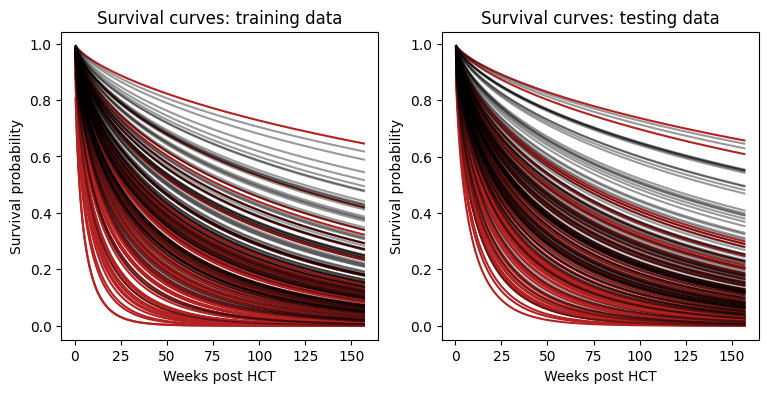

In [12]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title('Survival curves: training data')

for i in range(100):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(100):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Weeks post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title('Survival curves: testing data')

for i in range(100):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(100):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Weeks post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 4.2. Survival probability at 160 weeks

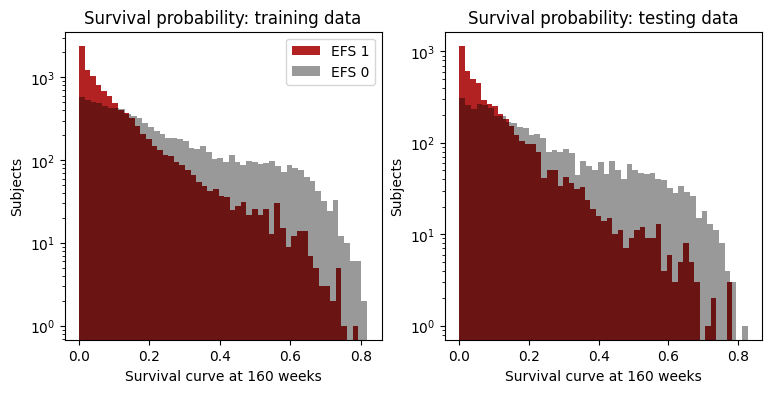

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df[156.819], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df[156.819], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at 160 weeks')
axs[0].set_ylabel('Subjects')
axs[0].set_yscale('log')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df[156.819], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df[156.819], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at 160 weeks')
axs[1].set_ylabel('Subjects')
axs[1].set_yscale('log')

plt.show()

### 4.3. Scoring

In [14]:
scoring_results=helper_funcs.score_predictions(
    model_description=f'WeibullAFT',
    predictions=testing_survival_df[156.819].reset_index(drop=True),
    labels_df=testing_labels_df,
    race_group=testing_race_group
)

print(scoring_results)

{'Model': ['WeibullAFT'], 'RMSE': [33.75107092123216], 'C-index': [np.float64(0.3500166339541648)], 'Stratified C-index': [0.4778893688417383]}


## 5. Save survival probabilities

### 5.1. Prep. complete dataset for Weibull-AFT regression

In [15]:
data_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)

efs_time=data_df['efs_time']
efs=data_df['efs']
data_df=data_df[feature_pvals[feature_pvals < 0.05].index].copy()
data_df['efs_time']=efs_time
data_df['efs']=efs

### 5.2. Fit Weibull-AFT model

In [16]:
cph_model=WeibullAFTFitter(penalizer=0.01)
cph_model.fit(data_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 28800 total observations, 13268 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
                penalizer = 0.01
   number of observations = 28800
number of events observed = 15532
           log-likelihood = -68237.65
         time fit was run = 2025-02-20 13:23:09 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                              
lambda_ age_at_hct                            -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        cardiac_Yes                           -0.51      0.60      0.04           -0.60           -0.42                0.55                0.65
        comorbidity_score                     -0.08      0.92      0.01           -0.09           -0.07                0.91                0.94
        conditioning_intensity_RIC            -0.28      0.76      0.02           -0.33           -0.23                0.72                0.79
        cyto_score                            -0.08      0.93      0.01           -0.10           -0.06                0.91                0.94
        cyto_score_detail                     -0.27      0.76      0.02           -0.30           -0.24                0.74                0.79
        diabetes_Yes                          -0.19      0.83      0.03           -0.24           -0.13                0.78                0.88
        dri_score                             -0.12      0.89      0.01           -0.13           -0.10                0.88                0.91
        graft_type_Peripheral blood           -0.19      0.82      0.05           -0.29           -0.10                0.75                0.90
        gvhd_proph_Cyclophosphamide +- others  0.23      1.25      0.04            0.14            0.31                1.15                1.37
        gvhd_proph_FK+ MMF +- others          -0.31      0.73      0.03           -0.36           -0.26                0.70                0.77
        gvhd_proph_Other GVHD Prophylaxis      0.23      1.26      0.09            0.04            0.41                1.05                1.51
        gvhd_proph_TDEPLETION +- other         0.29      1.33      0.10            0.08            0.49                1.09                1.64
        hepatic_mild_Yes                      -0.07      0.94      0.05           -0.16            0.02                0.86                1.02
        hepatic_severe_Yes                     0.34      1.40      0.06            0.22            0.46                1.25                1.58
        hla_match_a_low                        0.27      1.31      0.04            0.19            0.34                1.21                1.41
        hla_match_b_low                       -0.24      0.79      0.04           -0.32           -0.15                0.73                0.86
        hla_match_drb1_high                   -0.27      0.77      0.04           -0.35           -0.18                0.70                0.83
        hla_nmdp_6                             0.08      1.08      0.02            0.04            0.12                1.04                1.12
        in_vivo_tcd_Yes                        0.29      1.33      0.03            0.24            0.34                1.27                1.40
        karnofsky_score                        0.01      1.01      0.00            0.00            0.01                1.00                1.01
        mrd_hct_Positive                       0.11      1.12      0.03            0.06            0.17                1.06                1.18
        obesity_Yes                           -0.15      0.86      0.04           -0.23           -0.06                0.79                0.94
        peptic_ulcer_Yes     

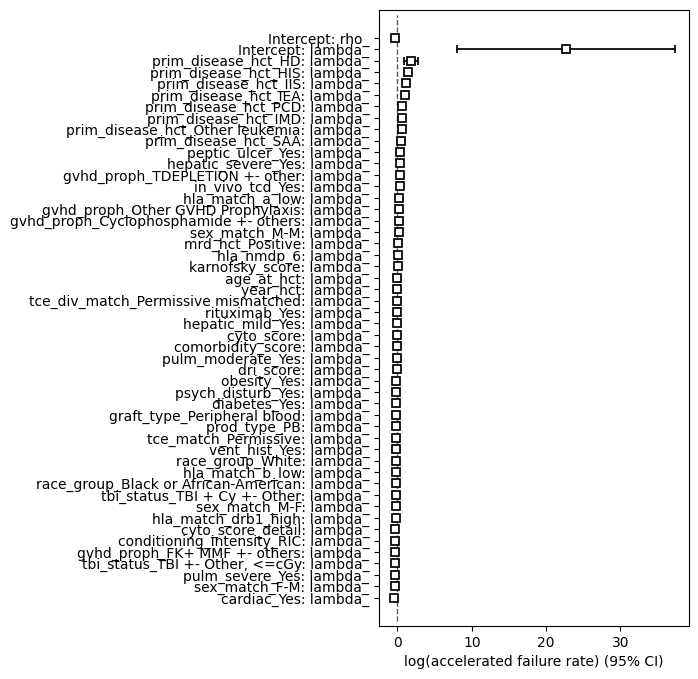

In [17]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

### 5.3. Forecast survival curve for all participants

In [18]:
survival_functions=cph_model.predict_survival_function(data_df)
survival_functions.to_parquet(survival_functions_file)
survival_functions.head()

ID,0,1,2,3,4,5,6,7,8,9,...,28790,28791,28792,28793,28794,28795,28796,28797,28798,28799
0.333,0.992281,0.979067,0.992765,0.976290,0.977275,0.945884,0.975330,0.983421,0.970989,0.976682,...,0.974559,0.972740,0.992386,0.994108,0.980234,0.980304,0.958336,0.933936,0.982460,0.990435
0.482,0.989981,0.972885,0.990609,0.969301,0.970572,0.930257,0.968062,0.978510,0.962467,0.969806,...,0.967068,0.964723,0.990117,0.992351,0.974392,0.974483,0.946202,0.915018,0.977269,0.987589
0.523,0.989388,0.971295,0.990053,0.967504,0.968848,0.926263,0.966194,0.977246,0.960278,0.968038,...,0.965142,0.962663,0.989532,0.991897,0.972888,0.972984,0.943093,0.910194,0.975932,0.986856
0.533,0.989246,0.970913,0.989919,0.967072,0.968434,0.925305,0.965745,0.976942,0.959753,0.967614,...,0.964680,0.962168,0.989392,0.991788,0.972527,0.972625,0.942347,0.909038,0.975611,0.986679
0.543,0.989104,0.970533,0.989786,0.966643,0.968022,0.924354,0.965299,0.976640,0.959230,0.967191,...,0.964220,0.961677,0.989252,0.991680,0.972168,0.972267,0.941606,0.907890,0.975292,0.986504


### 5.6. Survival probabilities at 160 weeks for all participants

In [19]:
survival_probabilities=survival_functions.iloc[-1]
survival_probabilities.rename('weibullaft_survival_probabilities', inplace=True)
survival_probabilities.reset_index(drop=True, inplace=True)
survival_probabilities.info()

<class 'pandas.core.series.Series'>
RangeIndex: 28800 entries, 0 to 28799
Series name: weibullaft_survival_probabilities
Non-Null Count  Dtype  
--------------  -----  
28800 non-null  float64
dtypes: float64(1)
memory usage: 225.1 KB


### Save predicted survival curves & probabilities

In [20]:
survival_functions.to_parquet(survival_functions_file)
survival_probabilities.to_frame().to_parquet(survival_probabilities_file)